# Model 1: ANN

## Import Necessary Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation

In [2]:
data_dir = '../Wildlife-Classification/Dataset'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/training")
print(len(classes),'classes :', classes)

Folders : ['training', 'validation']
3 classes : ['Cheetah', 'Hyena', 'Tiger']


In [3]:
dataset = ImageFolder(data_dir + '/training', transform=ToTensor())
print('Size of training dataset :', len(dataset))

Size of training dataset : 2700


In [4]:
test = ImageFolder(data_dir + '/validation', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of test dataset : 300


In [5]:
img, label = dataset[0]
print(img.shape)

torch.Size([3, 400, 400])


#### We check if the dataset has been imported successfully without any fault by showing an example having the image and the label as parameters. We use the permute function instead of the Reshape function, this is because while the permute function transposes the matrix of the image, it also does not allocate any memory and just displays a single image.

Label:  Cheetah (0)


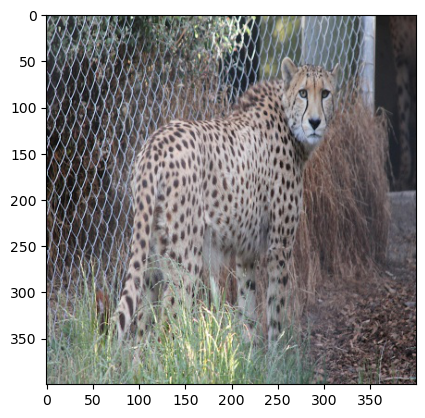

In [6]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[0])

Here, the 2020th image is displayed to showcase an example.

Label:  Tiger (2)


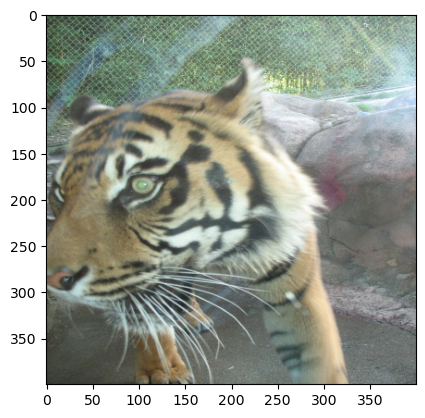

In [7]:
show_example(*dataset[2020])

Label:  Hyena (1)


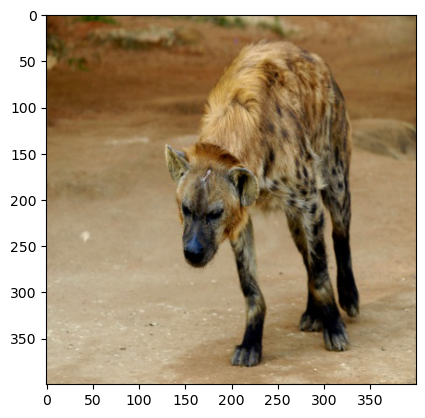

In [8]:
show_example(*dataset[1233])

#### torch.manual_seed(seed) - Sets the seed for generating random numbers. 43 is the starting point

In [9]:
torch.manual_seed(43)
val_size = 300
train_size = len(dataset) - val_size

#### Splitting Dataset into training and validation and doing it in a random fashion.

In [10]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2400, 300)

#### Batch Size is now decided as per using Gradient descent.

In [11]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)


In [12]:
!pip install jovian --upgrade -q

In [13]:
project_name = "Wildlife Classification"

#### Using jovian as a platform for sharing and collaborating on Jupyter notebook and committing the project.

In [14]:
import jovian
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ········
[jovian] Creating a new project "pranshu911/Wildlife Classification"
[jovian] Committed successfully! https://jovian.com/pranshu911/wildlife-classification


'https://jovian.com/pranshu911/wildlife-classification'

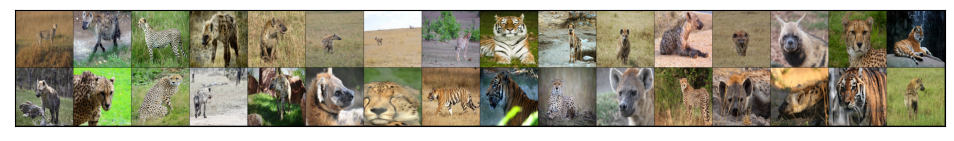

In [15]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

#### Accuracy function defined.

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [18]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
torch.cuda.is_available()

False

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [21]:
device = get_default_device()
device

device(type='cpu')

In [22]:
def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

In [23]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [24]:
input_size = 3*400*400
output_size = 3

#### Hidden layer will be defined in the next block of code with the number of training neurons

In [25]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.out_layer = nn.Linear(16, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

#### This line of code is creating an instance of a PyTorch model and moving it to a specified device, so that it can be trained and used for prediction.

In [26]:
model = to_device(Model(input_size, output_size), device)

In [27]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.0997869968414307, 'val_acc': 0.34062498807907104}]

In [28]:
history += fit(3, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0998, val_acc: 0.3423
Epoch [1], val_loss: 1.0947, val_acc: 0.3259
Epoch [2], val_loss: 1.0968, val_acc: 0.3861


In [29]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0699, val_acc: 0.4176
Epoch [1], val_loss: 1.0651, val_acc: 0.4290
Epoch [2], val_loss: 1.0619, val_acc: 0.4352
Epoch [3], val_loss: 1.0604, val_acc: 0.4384
Epoch [4], val_loss: 1.0588, val_acc: 0.4443
Epoch [5], val_loss: 1.0585, val_acc: 0.4446
Epoch [6], val_loss: 1.0582, val_acc: 0.4446
Epoch [7], val_loss: 1.0584, val_acc: 0.4415
Epoch [8], val_loss: 1.0583, val_acc: 0.4415
Epoch [9], val_loss: 1.0579, val_acc: 0.4460


In [30]:
history += fit(10, 0.02, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0728, val_acc: 0.4389
Epoch [1], val_loss: 1.0931, val_acc: 0.3960
Epoch [2], val_loss: 1.0574, val_acc: 0.4423
Epoch [3], val_loss: 1.1080, val_acc: 0.4119
Epoch [4], val_loss: 1.0474, val_acc: 0.4886
Epoch [5], val_loss: 1.0494, val_acc: 0.4702
Epoch [6], val_loss: 1.0406, val_acc: 0.4858
Epoch [7], val_loss: 1.0444, val_acc: 0.4702
Epoch [8], val_loss: 1.0366, val_acc: 0.4608
Epoch [9], val_loss: 1.0438, val_acc: 0.4861


#### Analyze the Model

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

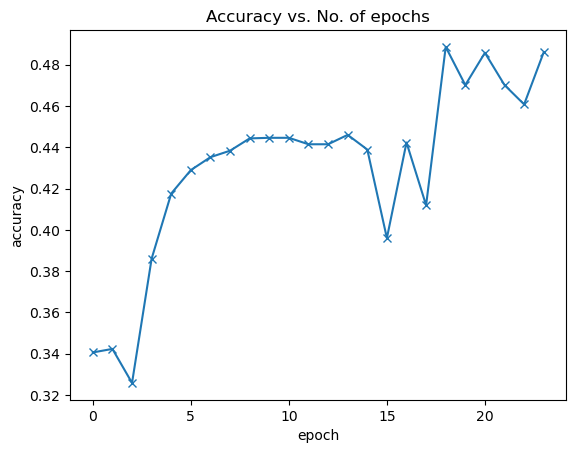

In [32]:
plot_accuracies(history)

In [33]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

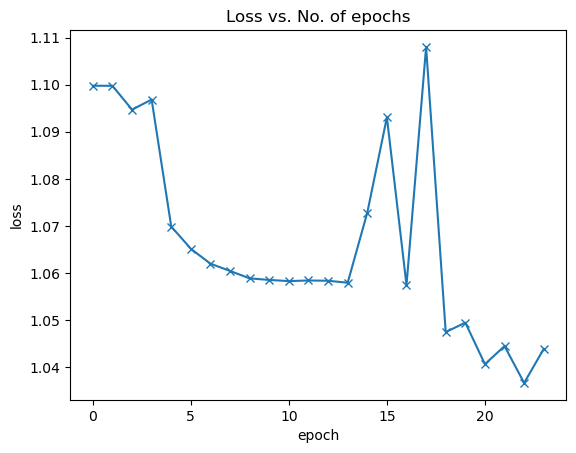

In [34]:
plot_losses(history)

In [35]:
evaluate(model, test_loader)

{'val_loss': 0.9714632034301758, 'val_acc': 0.5352272987365723}

The above model has an accuracy of 53.52%

# **Model 2 : Convolutional Neural Network**

![](http://)We will now try to train the model using CNN Resnet18

In [36]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [38]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)
simple_model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [39]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([32, 3, 400, 400])
out.shape: torch.Size([32, 8, 200, 200])


In [40]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [41]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d((3,400,400), 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 3))
        
    def forward(self, xb):
        return self.network(xb)

In [42]:
class CnnModel2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 3)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [43]:
model = CnnModel2()
model

C:\Users\PRANSHU CHOUBEY\anaconda3\envs\tfenv\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\PRANSHU CHOUBEY\anaconda3\envs\tfenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\PRANSHU CHOUBEY/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
52.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to 

CnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [44]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 400, 400])
out.shape: torch.Size([32, 3])
out[0]: tensor([0.6949, 0.6078, 0.5236], grad_fn=<SelectBackward0>)


In [45]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [46]:
device = get_default_device()
device

device(type='cpu')

In [47]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [48]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [49]:
model = to_device(CnnModel2(), device)

In [50]:
evaluate(model, val_loader)

{'val_loss': 1.111875057220459, 'val_acc': 0.3073863387107849}

In [51]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [52]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6143, val_loss: 0.7334, val_acc: 0.7966
Epoch [1], train_loss: 0.5886, val_loss: 0.7235, val_acc: 0.8216
Epoch [2], train_loss: 0.5764, val_loss: 0.6599, val_acc: 0.8759
Epoch [3], train_loss: 0.5668, val_loss: 0.5823, val_acc: 0.9736
Epoch [4], train_loss: 0.5639, val_loss: 0.6075, val_acc: 0.9426
Epoch [5], train_loss: 0.5632, val_loss: 0.5650, val_acc: 0.9906
Epoch [6], train_loss: 0.5561, val_loss: 0.5726, val_acc: 0.9801
Epoch [7], train_loss: 0.5549, val_loss: 0.5862, val_acc: 0.9582
Epoch [8], train_loss: 0.5608, val_loss: 0.6182, val_acc: 0.9321
Epoch [9], train_loss: 0.5656, val_loss: 0.5849, val_acc: 0.9676


Analyze the Model

In [53]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

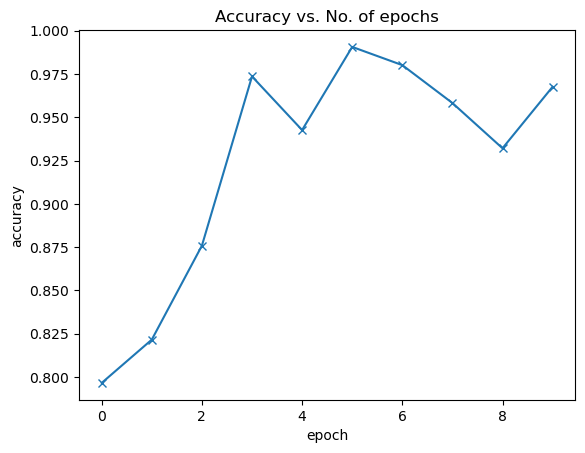

In [54]:
plot_accuracies(history)

In [55]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

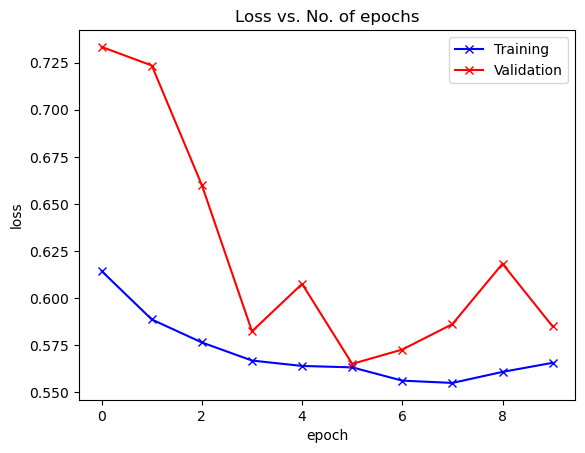

In [56]:
plot_losses(history)

In [57]:
evaluate(model, test_loader)

{'val_loss': 0.5840606689453125, 'val_acc': 0.9659091234207153}

The CNN model has an accuracy of 96.59% as compared to the previous one which had only 53.52%

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:
project_name = "Wildlife Classification CNN"

In [5]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pranshu911/wildlife-classification-cnn" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pranshu911/wildlife-classification-cnn


'https://jovian.com/pranshu911/wildlife-classification-cnn'